In [1]:
import numpy as np
import os
import random
import torch
import json
import cv2
import skimage
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from typing import Tuple, List
from baseline import Baseline
from deciwatch import DeciWatch
from unipose import Unipose
from unipose2 import Unipose2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

c:\Users\André\Desktop\master_thesis\venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_torso_diameter(keypoints):
    if np.all(keypoints[3] == [0, 0]) or np.all(keypoints[15] == [0, 0]) or np.all(keypoints[4] == [0, 0]) or np.all(keypoints[16] == [0, 0]):
        return None

    left_torso_diameter = np.linalg.norm(keypoints[3] - keypoints[15])
    right_torso_diameter = np.linalg.norm(keypoints[4] - keypoints[16])
    torso_diameter = np.mean([left_torso_diameter, right_torso_diameter])
    
    return torso_diameter


def heatmaps2coordinates(featuremaps):
    """
    Turns a video sequence of heatmaps into the equivalent
    sequence of keypoint coordinates.
    
    Parameters
    ----------
    featuremaps : Union[np.array, torch.Tensor]
        Video sequence of heatmaps
        
    Returns
    -------
    keypoints : torch.Tensor
        Keypoint coordinates.
    """
    
    assert len(featuremaps.shape) == 5, f"Your video sequence should have the following shape: (num_batches, num_frames, num_heatmaps, height, width). Yours have shape {featuremaps.shape}"
    
    # Extracting useful info
    num_batches, num_frames, num_heatmaps = featuremaps.shape[:3]
    
    # Casting featuremaps to numpy
    featuremaps = featuremaps.detach().cpu().numpy()
    
    # Dimensions of each keypoints
    num_dimensions = 2
    
    # Preallocating memory
    keypoints = torch.zeros((num_batches, num_frames, num_dimensions * num_heatmaps))
    
    for batch_idx in range(num_batches):
        for frame_idx in range(num_frames):
            for heatmap_idx in range(num_heatmaps):
                
                # Finds the coordinates of the keypoint-heatmap
                heatmap = featuremaps[batch_idx, frame_idx, heatmap_idx]
                coordinate = np.unravel_index(heatmap.argmax(), heatmap.shape)
                
                # Stores the keypoint-coordinate
                keypoints[batch_idx, frame_idx, num_dimensions * heatmap_idx] = coordinate[0]
                keypoints[batch_idx, frame_idx, num_dimensions * heatmap_idx + 1] = coordinate[1]

    return keypoints

def compute_PCK(all_gt_keypoints, all_pred_keypoints, norm):
    
    assert len(all_gt_keypoints.shape) in [3, 5]
    assert len(all_pred_keypoints.shape) in [3, 5]
    
    if len(all_gt_keypoints.shape) != 3:
        all_gt_keypoints = heatmaps2coordinates(all_gt_keypoints)
    else:
        all_gt_keypoints = all_gt_keypoints.detach().cpu().numpy()
        
    if len(all_pred_keypoints.shape) != 3:
        all_pred_keypoints = heatmaps2coordinates(all_pred_keypoints)
    else:
        all_pred_keypoints = all_pred_keypoints.detach().cpu().numpy()
        
    bools = []
        
    for batch in range(all_pred_keypoints.shape[0]):
        for frame in range(all_pred_keypoints.shape[1]):
            gt_keypoints = all_gt_keypoints[batch, frame]
            pred_keypoints = all_pred_keypoints[batch, frame]
    
            # Reshaping to 2d-coodinates
            gt_keypoints = gt_keypoints.reshape((-1, 2))
            pred_keypoints = pred_keypoints.reshape((-1, 2))
            
            # Getting the torso diameter
            torso_diameter = get_torso_diameter(gt_keypoints)
            if torso_diameter is None:
                continue

            # Removing unannotated rows
            pred_keypoints = pred_keypoints[gt_keypoints.any(axis=1)]
            gt_keypoints = gt_keypoints[gt_keypoints.any(axis=1)]
            
            if len(gt_keypoints) == 0:
                continue
            
            # Computing the distance between the groundtruthh keypoints
            # and the predicted keypoints
            dist = np.linalg.norm(gt_keypoints - pred_keypoints, axis=1)
            
            # Checking whether the distances are shorter than the torso diameter
            dist = dist <= torso_diameter * norm
            
            # Storing results of this batch-frame
            bools.append(dist.flatten())
        
    # Returning the ratio of correctly predicted keypoints
    bools = np.concatenate(bools)
    return -1 if len(bools) == 0 else np.mean(bools)

def evaluate(model,
             dataloader: DataLoader,  
             device: torch.device, 
             norm: float = 0.2,
             data_transformer = lambda x: x,
             compute_pck = True):
    """
    Evaluates a model on a dataloader using a criterion and PCK
    
    Parameters
    ----------
    model : nn.Module
        Model to evaluate
    
    dataloader: DataLoader
        Dataloader to evaluate the model on
        
    criterion : type
        Loss-function to use for evaluation
        
    device : torch.device
        Device to use for processing
        
    norm : float    
        Normalizing-value for PCK
        
    data_transformer : Callable
        Any transformation to apply to the input data
        prior to it being inputted to the model, as well as
        any transformation to apply to the target data
        prior to it being used for computing loss.
    
    Returns
    -------
    losses_mean : float
        Average loss of the model on the dataloder
    
    PCK_mean : float
        Average PCK of the model on the dataloader
    """
    
    # Pre-allocating memory for storing info
    PCKs = []
    
    # Looping through dataloader
    with torch.no_grad():
        for i, (x, y, is_pa) in tqdm(enumerate(dataloader), leave=False, desc="Evaluating", disable=False, total=len(dataloader)):
                        
            # Storing data on device
            x = data_transformer(x).float().to(device)
            y = data_transformer(y).float().to(device)
            
            # Predicting
            pred = model(x)

            PCK = compute_PCK(y, pred, norm)
            if PCK != -1:
                PCKs.append(PCK) 

    # Computing mean PCK and loss
    PCK_mean = np.mean(PCKs) if compute_pck else []
    
    return PCK_mean

In [3]:
def get_torso_diameter(keypoints):
    if np.all(keypoints[3] == [0, 0]) or np.all(keypoints[15] == [0, 0]) or np.all(keypoints[4] == [0, 0]) or np.all(keypoints[16] == [0, 0]):
        return None

    left_torso_diameter = np.linalg.norm(keypoints[3] - keypoints[15])
    right_torso_diameter = np.linalg.norm(keypoints[4] - keypoints[16])
    torso_diameter = np.mean([left_torso_diameter, right_torso_diameter])
    
    return torso_diameter


def heatmaps2coordinates(featuremaps):
    """
    Turns a video sequence of heatmaps into the equivalent
    sequence of keypoint coordinates.
    
    Parameters
    ----------
    featuremaps : Union[np.array, torch.Tensor]
        Video sequence of heatmaps
        
    Returns
    -------
    keypoints : torch.Tensor
        Keypoint coordinates.
    """
    
    assert len(featuremaps.shape) == 5, f"Your video sequence should have the following shape: (num_batches, num_frames, num_heatmaps, height, width). Yours have shape {featuremaps.shape}"
    
    # Extracting useful info
    num_batches, num_frames, num_heatmaps = featuremaps.shape[:3]
    
    # Casting featuremaps to numpy
    featuremaps = featuremaps.detach().cpu().numpy()
    
    # Dimensions of each keypoints
    num_dimensions = 2
    
    # Preallocating memory
    keypoints = torch.zeros((num_batches, num_frames, num_dimensions * num_heatmaps))
    
    for batch_idx in range(num_batches):
        for frame_idx in range(num_frames):
            for heatmap_idx in range(num_heatmaps):
                
                # Finds the coordinates of the keypoint-heatmap
                heatmap = featuremaps[batch_idx, frame_idx, heatmap_idx]
                coordinate = np.unravel_index(heatmap.argmax(), heatmap.shape)
                
                # Stores the keypoint-coordinate
                keypoints[batch_idx, frame_idx, num_dimensions * heatmap_idx] = coordinate[0]
                keypoints[batch_idx, frame_idx, num_dimensions * heatmap_idx + 1] = coordinate[1]

    return keypoints

def compute_PCK(all_gt_keypoints, all_pred_keypoints, norm):
    
    assert len(all_gt_keypoints.shape) in [3, 5]
    assert len(all_pred_keypoints.shape) in [3, 5]
    
    if len(all_gt_keypoints.shape) != 3:
        all_gt_keypoints = heatmaps2coordinates(all_gt_keypoints)
    else:
        all_gt_keypoints = all_gt_keypoints.detach().cpu().numpy()
        
    if len(all_pred_keypoints.shape) != 3:
        all_pred_keypoints = heatmaps2coordinates(all_pred_keypoints)
    else:
        all_pred_keypoints = all_pred_keypoints.detach().cpu().numpy()
        
    bools = []
        
    for batch in range(all_pred_keypoints.shape[0]):
        for frame in range(all_pred_keypoints.shape[1]):
            gt_keypoints = all_gt_keypoints[batch, frame]
            pred_keypoints = all_pred_keypoints[batch, frame]
    
            # Reshaping to 2d-coodinates
            gt_keypoints = gt_keypoints.reshape((-1, 2))
            pred_keypoints = pred_keypoints.reshape((-1, 2))
            
            # Getting the torso diameter
            torso_diameter = get_torso_diameter(gt_keypoints)
            if torso_diameter is None:
                continue

            # Removing unannotated rows
            pred_keypoints = pred_keypoints[gt_keypoints.any(axis=1)]
            gt_keypoints = gt_keypoints[gt_keypoints.any(axis=1)]
            
            if len(gt_keypoints) == 0:
                continue
            
            # Computing the distance between the groundtruthh keypoints
            # and the predicted keypoints
            dist = np.linalg.norm(gt_keypoints - pred_keypoints, axis=1)
            
            # Checking whether the distances are shorter than the torso diameter
            dist = dist <= torso_diameter * norm
            
            # Storing results of this batch-frame
            bools.append(dist.flatten())
        
    # Returning the ratio of correctly predicted keypoints
    bools = np.concatenate(bools)
    return -1 if len(bools) == 0 else np.mean(bools)

In [4]:
class _ClimbAlongDataset():
    def __init__(self, dir_path: str, window_size: int, heatmap_shape: Tuple[int, int, int], train_ratio: float, interval_skip: int = 0, upper_range: int = 1, augment_data: bool = False):
        """
        ClimbAlong dataset
        
        Parameters
        ----------
        dir_path : str
            Path to the data-directory.
            Should end with a "/"
            
        window_size : int
            Amount of frames to load at a time
            
        heatmap_shape : Tuple[int, int, int]
            Shape of a single heatmap
            
        train_ratio : float
            Ratio of data to use for evaluation
            
        interval_skip: int
            Number of frames to skip when loading the data
            
        upper_range: int
            Upper range of the data
        """
        
        self.augment_data = augment_data
        
        # Upper range of the data
        self.upper_range = upper_range
        
        # Ratio of data to use for evaluation
        self.train_ratio = train_ratio
        
        # Path to input directory
        self.input_dir = dir_path + "input/"
        
        # Path to target directory
        self.target_dir = dir_path + "target/"
        
        # Amount of frames to load at a time
        self.window_size = window_size
        
        # Number of frames to skip when loading the data
        self.interval_skip = interval_skip + 1
        
        # Mapping from index to sample
        if self.train_ratio > 0:
            self.train_mapper, self.test_mapper, self.val_mapper = self._get_mapper()
        else:
            self.val_mapper = self._get_mapper()
        
        self.heatmap_shape = heatmap_shape
        
    def _remove_train_eval_overalap(self, train_mapper, eval_mapper):
        """
        Moves any windows in the eval_mapper with an overlapping frame in the train_mapper
        over to the train_mapper
        """
        
        # Set of frame-names of the train_mapper
        train_mapper_samples = {sample_name for window in list(train_mapper.values()) for sample_name in window}
        
        # Dict of the new eval_mapper
        new_eval_mapper = {}
        
        # Looping through all of the windows of the eval_mapper
        for window in eval_mapper.values():
            
            # Variable for keeping track of whether any of the frames of the current 
            # window exists in the train_mapepr
            non_overlap = True
            
            # Looping through the frames of the current frame
            for sample_name in window:
                
                # If the current frame also exists in the train_mapper
                if sample_name in train_mapper_samples:
                    
                    # Add the current window to the train_mapper
                    train_mapper[len(train_mapper)] = window
                    
                    # Adds all of the names of the frames of the window
                    # to the set of frame-samples of the train_mapper
                    for sample_name in window:
                        train_mapper_samples.add(sample_name)
                    
                    non_overlap = False
                    break
                
            # If there has not been an overlap
            # add the window to the new_eval_mapper
            if non_overlap:
                new_eval_mapper[len(new_eval_mapper)] = window
                
        return train_mapper, new_eval_mapper
    
    def _prune_mapper(self, mapper):
        """
        Prunes the mapper, such that it has no overlapping windows.
        """
        
        return dict(list(mapper.items())[::self.window_size])
        
    def _get_mapper(self):
        """
        Function for loading dataset.
        
        Returns
        -------
        mapper : dict
            Dictionary that maps from an index to the corresponding samples
        """
        
        # Dict that maps from index to samples
        mapper = {}
        
        # Name of all clips
        clips = os.listdir(self.input_dir)
        
        # Looping through each clip
        for clip_name in tqdm(clips, desc="Loading dataset", leave=False):
            
            if clip_name == ".DS_Store":
                continue
            
            # Names of the frames of the current clip
            frames = os.listdir(self.input_dir + clip_name)
            
            # If the clip is a BRACE_clip, extract the lower interval
            # If not, we use 0 as the lower interval
            if "_" in clip_name and len(clip_name.split("_")) > 2 and clip_name.split("_")[0] != "VID":
                lower_interval = int(clip_name.split("_")[-2])
            else:
                lower_interval = 0
                
            # Number of samples for this clip
            num_samples = len(frames) - self.interval_skip * self.window_size + self.interval_skip
            
            # Saving each sample in the mapper
            # with its corresponding index
            for sample in range(num_samples):
                if sample + self.window_size * self.interval_skip > len(frames):
                    break
                
                mapper[len(mapper)] = [clip_name + "/" + str(lower_interval + sample + window_ele * self.interval_skip) + ".pt" for window_ele in range(self.window_size)]
        
        # Splits the mapper into training and evaluation
        if self.train_ratio > 0:
            train_mapper = dict(list(mapper.items())[int(len(mapper) * (1 - self.train_ratio)):])
            eval_mapper = dict(list(mapper.items())[:int(len(mapper) * (1 - self.train_ratio))])
            
            # Removes the overlapping frames of the two mappers
            train_mapper, eval_mapper = self._remove_train_eval_overalap(train_mapper, eval_mapper)
            
            # Prunes the eval_mapper such that it has no overlapping windows
            eval_mapper = self._prune_mapper(eval_mapper)
            
            # Splits the evaluation mapper into testing and validation
            test_mapper = dict(list(eval_mapper.items())[0::2])
            val_mapper = dict(list(eval_mapper.items())[1::2])
            
            # Resetitng the indicies of the mappers
            train_mapper = {i: v for i, v in enumerate(train_mapper.values())}
            test_mapper = {i: v for i, v in enumerate(test_mapper.values())}
            val_mapper = {i: v for i, v in enumerate(val_mapper.values())}
            
            return train_mapper, test_mapper, val_mapper
        else:
            val_mapper = {i: v for i, v in enumerate(mapper.values())}
            return val_mapper
    
    class _CA_subdataset(Dataset):
        def __init__(self, mapper, window_size: int, upper_range: int, heatmap_shape: Tuple[int, int, int], input_dir: str, target_dir: str, augment_data: bool):
            
            # Dict that contains the mapping from index to data
            self.mapper = mapper
            
            # Size of each window
            self.window_size = window_size
            
            # Upper range of each sample
            self.upper_range = upper_range
            
            # Shape of the heatmaps that will be loaded
            self.heatmap_shape = heatmap_shape
            
            # Path to where the input data is stored
            self.input_dir = input_dir
            
            # Path to where the target data is stored
            self.target_dir = target_dir
            
            self.augment_data = augment_data
        
        def __len__(self):
            return len(self.mapper)
        
        def __getitem__(self, i: int):
            sample_names = self.mapper[i]
            
            input_samples = torch.zeros((len(sample_names), *self.heatmap_shape), dtype=float)
            target_samples = torch.zeros((len(sample_names), *self.heatmap_shape), dtype=float)
            frames = []
            
            for j, sample_name in enumerate(sample_names):
                input_samples[j] = torch.load(self.input_dir + sample_name) * self.upper_range
                target_samples[j] = torch.load(self.target_dir + sample_name) * self.upper_range
                frames.append(int(sample_name.split("/")[1][:-3])) #'20220801_155032/1.pt'
                
            if self.augment_data:
                angle = random.randint(-45, 45)
                input_samples = TF.rotate(input_samples, angle)
                target_samples = TF.rotate(target_samples, angle)

            return input_samples, target_samples, frames
        
    def get_datasets(self):
        """
        Function for getting the three datasets.
        """
        
        if self.train_ratio > 0:
            train_dataset = self._CA_subdataset(self.train_mapper, self.window_size, self.upper_range, self.heatmap_shape, self.input_dir, self.target_dir, self.augment_data)
            test_dataset = self._CA_subdataset(self.test_mapper, self.window_size, self.upper_range, self.heatmap_shape, self.input_dir, self.target_dir, False)
            val_dataset = self._CA_subdataset(self.val_mapper, self.window_size, self.upper_range, self.heatmap_shape, self.input_dir, self.target_dir, False)
            
            return train_dataset, test_dataset, val_dataset
        else:
            return self._CA_subdataset(self.val_mapper, self.window_size, self.upper_range, self.heatmap_shape, self.input_dir, self.target_dir, False)

In [5]:
def get_dataloaders(dir_path: str, 
                    window_size: int, 
                    batch_size: int, 
                    eval_ratio: float, 
                    heatmap_shape: Tuple[int, int, int] = (25, 56, 56), 
                    num_workers: int = 0,
                    interval_skip: int = 0,
                    input_name: str = "input",
                    upper_range: int = 1,
                    dataset_type: str = "pretrain",
                    augment_data: bool = False,
                    ):
    """
    Function for getting train-, validation- and test-dataloader.
    
    Parameters
    ----------
    dir_path : str
        Path to folder of processed samples
        
    window_size : int
        Amount of frames to load at a time
        
    batch_size : int
        Amount of samples to receive at a time
        
    eval_ratio : float
        Ratio of data that should be used for evaluating the model.
        
    heatmap_shape : Tuple[int, int, int]
        Shape of a single heatmap
        
    num_workers : int
        Number of workers to use when loading data
        
    Returns
    -------
    train_loader : DataLoader
        Train-dataloader
    
    val_loader : DataLoader
        Validation-dataloader
        
    test_loader : DataLoader
        Test-dataloader
        
    interval_skip : int
        Number of frames to skip when loading the data
    """
    
    assert dataset_type.lower() in ["pretrain", "ca", "climbalong"]
    
    if dataset_type.lower() == "pretrain":
    
        # Loading pretrained dataset
        total_dataset = _PretrainDataSet(dir_path, window_size, heatmap_shape, interval_skip, input_name, upper_range)
        
        # Splitting dataset into three subsets
        dataset_len = len(total_dataset)
        indices = list(range(dataset_len))
        train_indices, test_indices = train_test_split(indices, test_size=eval_ratio, shuffle=False)
        val_indices, test_indices = train_test_split(test_indices, test_size=0.5, shuffle=False)
        
        # Shuffling the three subsets indipendently
        train_sampler = SubsetRandomSampler(train_indices)
        val_sampler = SubsetRandomSampler(val_indices)
        test_sampler = SubsetRandomSampler(test_indices)
        
        # Creating dataloaders
        train_loader = DataLoader(total_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
        val_loader = DataLoader(total_dataset, batch_size=batch_size, sampler=val_sampler, num_workers=num_workers)
        test_loader = DataLoader(total_dataset, batch_size=batch_size, sampler=test_sampler, num_workers=num_workers)
        
        data_loaders = (train_loader, val_loader, test_loader)
        
    else:
        
        if eval_ratio != 1:
            # Loading the datasets
            total_dataset = _ClimbAlongDataset(dir_path, window_size, heatmap_shape, 1 - eval_ratio, interval_skip, upper_range, augment_data)
            train_dataset, test_dataset, val_dataset = total_dataset.get_datasets()
            
            # Creating dataloaders
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
            val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
            test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
            
            data_loaders = (train_loader, val_loader, test_loader)
        else:
            total_dataset = _ClimbAlongDataset(dir_path, window_size, heatmap_shape, 1 - eval_ratio, interval_skip, upper_range, False)
            val_dataset = total_dataset.get_datasets()
            val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
            data_loaders = val_loader
        
    
    return data_loaders

In [6]:
data_dir = "../../data/processed/ClimbAlong/testing/"

dataloader_no_skip = get_dataloaders(
    data_dir,
    5,
    1,
    eval_ratio=1,
    num_workers=0,
    interval_skip=0,
    upper_range=255,
    dataset_type="CA"
)

dataloader_skip = get_dataloaders(
    data_dir,
    5,
    1,
    eval_ratio=1,
    num_workers=0,
    interval_skip=1,
    upper_range=255,
    dataset_type="CA"
)

dataset_no_skip = dataloader_no_skip.dataset
dataset_skip = dataloader_skip.dataset

In [7]:
def get_model_config(model_path, model_type):
    with open(model_path.replace("finetuned_models", "pretrained_models") + "config.json", "r") as f:
        config = json.load(f)
      
    if model_type != "baseline":
        config["model_params"]["device"] = device
        
    if model_type in ["unipose", "unipose2"]:
        config["model_params"]["upper_range"] = 255
        
    return config["model_params"]

In [8]:
def heatmaps2coordinates(featuremaps):
    """
    Turns a video sequence of heatmaps into the equivalent
    sequence of keypoint coordinates.
    
    Parameters
    ----------
    featuremaps : Union[np.array, torch.Tensor]
        Video sequence of heatmaps
        
    Returns
    -------
    keypoints : torch.Tensor
        Keypoint coordinates.
    """
    
    assert len(featuremaps.shape) == 5, f"Your video sequence should have the following shape: (num_batches, num_frames, num_heatmaps, height, width). Yours have shape {featuremaps.shape}"
    
    # Extracting useful info
    num_batches, num_frames, num_heatmaps = featuremaps.shape[:3]
    
    # Casting featuremaps to numpy
    featuremaps = featuremaps.detach().cpu().numpy()
    
    # Dimensions of each keypoints
    num_dimensions = 2
    
    # Preallocating memory
    keypoints = torch.zeros((num_batches, num_frames, num_dimensions * num_heatmaps))
    
    for batch_idx in range(num_batches):
        for frame_idx in range(num_frames):
            for heatmap_idx in range(num_heatmaps):
                
                # Finds the coordinates of the keypoint-heatmap
                heatmap = featuremaps[batch_idx, frame_idx, heatmap_idx]
                coordinate = np.unravel_index(heatmap.argmax(), heatmap.shape)
                
                # Stores the keypoint-coordinate
                keypoints[batch_idx, frame_idx, num_dimensions * heatmap_idx] = coordinate[0]
                keypoints[batch_idx, frame_idx, num_dimensions * heatmap_idx + 1] = coordinate[1]

    return keypoints

In [9]:
def get_video_frame(frame_idx, video_path):
    video_bboxes = np.load(video_path.replace("video", "input").replace(".mp4", ".npz"))["bboxes"]
    
    cap = cv2.VideoCapture(video_path)
    i = 0

    while(cap.isOpened()):
        ret, frame = cap.read()
        if ret == True:
            if i == frame_idx:
                break

            i += 1
        else:
            raise("ERROR")
        
    frame = frame[..., ::-1]
    frame_bbox = np.round(video_bboxes[frame_idx].squeeze()).astype(int)
    frame = frame[frame_bbox[1]:frame_bbox[3], frame_bbox[0]:frame_bbox[2]]
    
    return frame, frame_bbox

In [10]:
def draw_keypoints(frame, keypoints, width_scale, height_scale, c="blue", radius=5):
    keypoints = keypoints.reshape((-1, 2))
    
    cs = {"red": [255, 0, 0], "green": [0, 255,0], "blue": [0, 0, 255]}
    frame_new = np.copy(frame)
    keypoints[:, 0] *= height_scale
    keypoints[:, 1] *= width_scale
    keypoints = np.round(keypoints).astype(int)
    
    for keypoint in keypoints:
        rr, cc = skimage.draw.disk(keypoint, radius)
        frame_new[rr, cc] = cs[c]
        
    return frame_new

In [11]:
data_transforms = {"baseline": lambda x: x, "unipose": lambda x: x, "unipose2": lambda x: x, "deciwatch": lambda x: heatmaps2coordinates(x.cpu()).to(device)}

In [12]:
video_path = "C:/Users/André/Desktop/master_thesis/data/raw/ClimbAlong/video/20220801_155032.mp4"

baseline_path = "C:/Users/André/Desktop/master_thesis/finetuned_models/1/baseline_1684430534.955375/20/model.pth"
deciwatch_path = "C:/Users/André/Desktop/master_thesis/pretrained_models/1/deciwatch_1684938562.615292/2/model.pth"
unipose_path = "C:/Users/André/Desktop/master_thesis/finetuned_models/1/unipose_1684317796.0789783/1/model.pth"
unipose2_path = "C:/Users/André/Desktop/master_thesis/finetuned_models/1/unipose2_1684251989.2482302/1/model.pth"

best_baseline_config = get_model_config("C:/Users/André/Desktop/master_thesis/finetuned_models/1/baseline_1684430534.955375/", "baseline")
baseline = Baseline(**best_baseline_config)
baseline.load_state_dict(torch.load(baseline_path, map_location=torch.device("cpu")))
baseline.eval()
baseline = baseline.to(device)    

best_deciwatch_config = get_model_config("C:/Users/André/Desktop/master_thesis/pretrained_models/1/deciwatch_1684938562.615292/", "deciwatch")
deciwatch = DeciWatch(**best_deciwatch_config)
deciwatch.load_state_dict(torch.load(deciwatch_path, map_location=torch.device("cpu")))
deciwatch.eval()
deciwatch = deciwatch.to(device)  

best_unipose_config = get_model_config("C:/Users/André/Desktop/master_thesis/finetuned_models/1/unipose_1684317796.0789783/", "unipose")
unipose = Unipose(**best_unipose_config)
unipose.load_state_dict(torch.load(unipose_path, map_location=torch.device("cpu")))
unipose.eval()
unipose = unipose.to(device)  

best_unipose2_config = get_model_config("C:/Users/André/Desktop/master_thesis/finetuned_models/1/unipose2_1684251989.2482302/", "unipose2")
unipose2 = Unipose2(**best_unipose2_config)
unipose2.load_state_dict(torch.load(unipose2_path, map_location=torch.device("cpu")))
unipose2.eval()
unipose2 = unipose2.to(device)

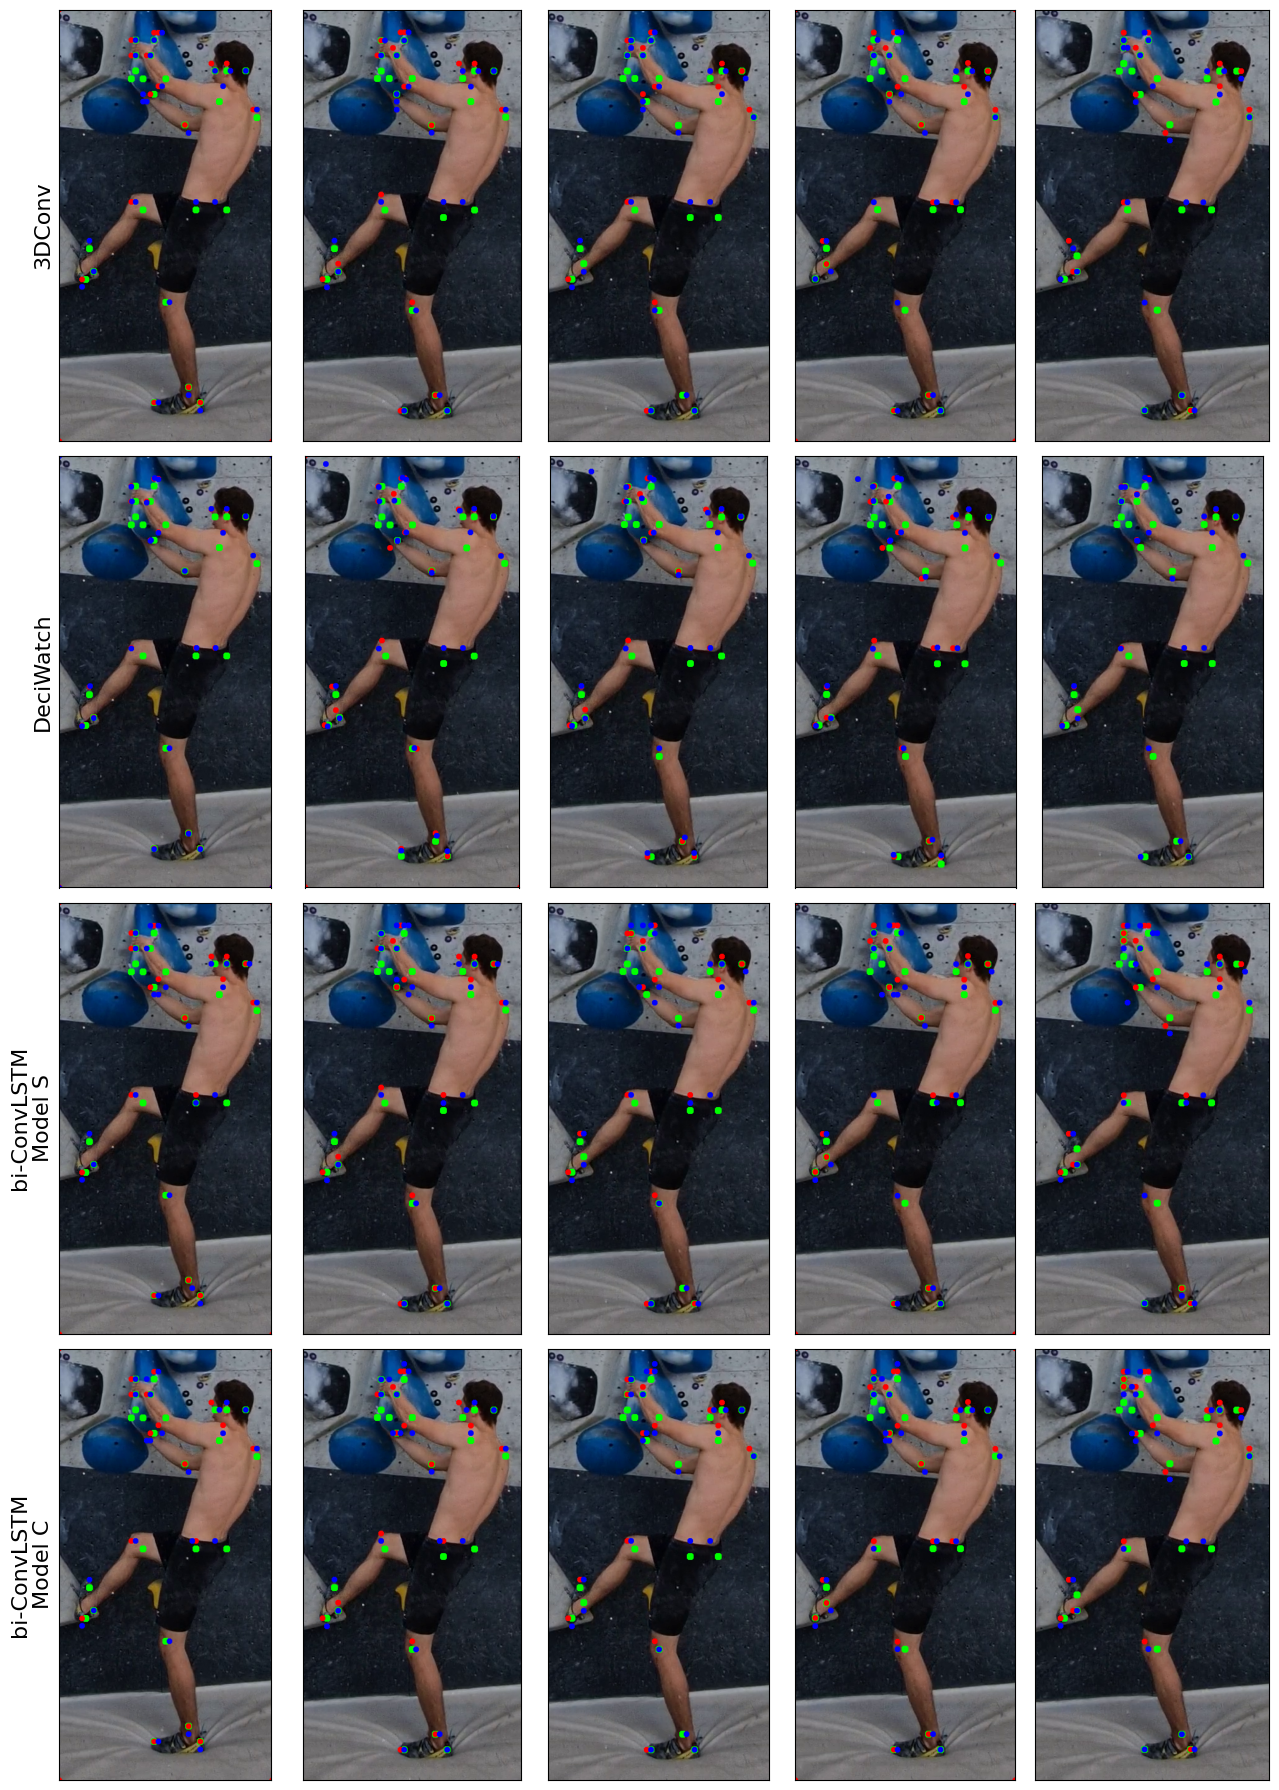

In [13]:
idx = 10

input_no_skips_heatmaps = dataset_no_skip[idx][0].unsqueeze(0).float().to(device)
gt_no_skips_heatmaps = dataset_no_skip[idx][1].unsqueeze(0).float().to(device)
frames_number_no_skip = dataset_no_skip[idx][2]

input_skips_heatmaps = dataset_skip[idx][0].unsqueeze(0).float().to(device)
gt_skips_heatmaps = dataset_skip[idx][1].unsqueeze(0).float().to(device)
frames_number_skip = dataset_skip[idx][2]

baseline_pred = baseline(input_skips_heatmaps)
deciwatch_pred = deciwatch(heatmaps2coordinates(input_no_skips_heatmaps.cpu()).to(device))
unipose_pred = unipose(input_skips_heatmaps)
unipose2_pred = unipose2(input_skips_heatmaps)

gt_no_skips_kpts = heatmaps2coordinates(gt_no_skips_heatmaps).detach().cpu().numpy().squeeze()
gt_skips_kpts = heatmaps2coordinates(gt_skips_heatmaps).detach().cpu().numpy().squeeze()

input_no_skips_kpts = heatmaps2coordinates(input_no_skips_heatmaps).detach().cpu().numpy().squeeze()
input_kips_kpts = heatmaps2coordinates(input_skips_heatmaps).detach().cpu().numpy().squeeze()

baseline_kpts = heatmaps2coordinates(baseline_pred).detach().cpu().numpy().squeeze()
deciwatch_kpts = deciwatch_pred.detach().cpu().numpy().squeeze()
unipose_kpts = heatmaps2coordinates(unipose_pred).detach().cpu().numpy().squeeze()
unipose2_kpts = heatmaps2coordinates(unipose2_pred).detach().cpu().numpy().squeeze()

frames_no_skip = []
bboxes_no_skip = []
for frame_number in frames_number_no_skip:
    frame, bbox = get_video_frame(frame_number, video_path)
    frames_no_skip.append(frame)
    bboxes_no_skip.append(bbox)
    
frames_skip = []
bboxes_skip = []
for frame_number in frames_number_skip:
    frame, bbox = get_video_frame(frame_number, video_path)
    frames_skip.append(frame)
    bboxes_skip.append(bbox)

# Radius of drawn disk
radius = 8

# Fontsize
fontsize = 16

# Making plt figure
fig, axs = plt.subplots(4, 5, figsize=(13, 18))
for j in range(4):
    for i in range(5):
        axs[j, i].set_yticklabels([])
        axs[j, i].set_xticklabels([])
        axs[j, i].set_xticks([])
        axs[j, i].set_yticks([])
        
axs[0, 0].set_ylabel("3DConv", fontsize=fontsize)
axs[1, 0].set_ylabel("DeciWatch", fontsize=fontsize)
axs[2, 0].set_ylabel("bi-ConvLSTM\nModel S", fontsize=fontsize)
axs[3, 0].set_ylabel("bi-ConvLSTM\nModel C", fontsize=fontsize)
    
for frame_idx in range(5):
    
    # Loading rescaling parameters
    width_scale_no_skip = (bboxes_no_skip[frame_idx][2] - bboxes_no_skip[frame_idx][0])/56
    height_scale_no_skip = (bboxes_no_skip[frame_idx][3] - bboxes_no_skip[frame_idx][1])/56
    
    width_scale_skip = (bboxes_skip[frame_idx][2] - bboxes_skip[frame_idx][0])/56
    height_scale_skip = (bboxes_skip[frame_idx][3] - bboxes_skip[frame_idx][1])/56
    
    frame_no_skip = frames_no_skip[frame_idx]
    frame_skip = frames_skip[frame_idx]
    
    gt_kp_no_skip = gt_no_skips_kpts[frame_idx]
    gt_kp_skip = gt_skips_kpts[frame_idx]
    
    input_no_skips_kpt = input_no_skips_kpts[frame_idx]
    input_skips_kpt = input_kips_kpts[frame_idx]
    
    frame_skip = draw_keypoints(frame_skip, gt_kp_skip, width_scale_skip, height_scale_skip, c="green", radius=6)
    frame_no_skip = draw_keypoints(frame_no_skip, gt_kp_no_skip, width_scale_no_skip, height_scale_no_skip, c="green", radius=6)
    
    frame_skip = draw_keypoints(frame_skip, input_skips_kpt, width_scale_skip, height_scale_skip, c="red", radius=5)
    frame_no_skip = draw_keypoints(frame_no_skip, input_no_skips_kpt, width_scale_no_skip, height_scale_no_skip, c="red", radius=5)
    
    baseline_kpt = baseline_kpts[frame_idx]
    baseline_frame = draw_keypoints(frame_skip, baseline_kpt, width_scale_skip, height_scale_skip, c="blue", radius=5)
    axs[0, frame_idx].imshow(baseline_frame)
    
    deciwatch_kpt = deciwatch_kpts[frame_idx]
    deciwatch_frame = draw_keypoints(frame_no_skip, deciwatch_kpt, width_scale_no_skip, height_scale_no_skip, c="blue", radius=5)
    axs[1, frame_idx].imshow(deciwatch_frame)
    
    unipose_kpt = unipose_kpts[frame_idx]
    unipose_frame = draw_keypoints(frame_skip, unipose_kpt, width_scale_skip, height_scale_skip, c="blue", radius=5)
    axs[2, frame_idx].imshow(unipose_frame)
    
    unipose2_kpt = unipose2_kpts[frame_idx]
    unipose2_frame = draw_keypoints(frame_skip, unipose2_kpt, width_scale_skip, height_scale_skip, c="blue", radius=5)
    axs[3, frame_idx].imshow(unipose2_frame)
    
plt.tight_layout()
plt.show()